# Average Daily Temperatures in Colorado (2010-2020)
**[NOAA](https://data.noaa.gov/dataset/dataset/global-surface-summary-of-the-day-gsod) Global Surface Summary of the Day**

*Step 1: Import Python modules and define helper functions*

In [1]:
from mpl_toolkits.basemap import Basemap
import folium
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import pycountry
import datetime
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
import bq_helper
from bq_helper import BigQueryHelper
helper = BigQueryHelper('bigquery-public-data', 'noaa_gsod')

def plotPointsOnMap(dataframe,beginIndex,endIndex,latitudeColumn,latitudeValue,longitudeColumn,longitudeValue,zoom):
    df = dataframe[beginIndex:endIndex]
    location = [latitudeValue,longitudeValue]
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.name[i:i+1]))
        folium.Marker([df[latitudeColumn].iloc[i],df[longitudeColumn].iloc[i]],popup=popup).add_to(plot)
    return(plot)

def color_coded_map(df, center_lat, center_lon, zoom):  
    # Adapted from  https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps
    m = folium.Map(location=[center_lat, center_lon],
                   zoom_start = zoom)
    for index, row in df.iterrows():
        folium.CircleMarker( [row['lat'], row['lon']] , radius=10, 
                             color=custom_colormap(row['avg_temp']), 
                             fill=True, fill_opacity=1.0,            
                             fill_color=custom_colormap(row['avg_temp']), 
                             popup=row['name'] ).add_to(m)
    custom_colormap.add_to(m)
    folium.TileLayer(tiles='Stamen Toner',name="Stamen Toner").add_to(m)
    folium.TileLayer(tiles='Stamen Terrain',name="Stamen Terrain").add_to(m)
    folium.TileLayer(tiles='cartodbpositron',name="cartodbpositron").add_to(m)
    folium.LayerControl().add_to(m)       
    return m

def mapAvgTemperature(df,latitude,longitude):
    # adapted from https://www.kaggle.com/anhuang/visualization-of-global-climatic-change
    df_ = df#.sample(5000)
    m = Basemap(projection='aea',lat_0=latitude, lon_0=longitude, resolution='l', area_thresh=1,rsphere=1,height=1, width=1)# projection='cyl'
    m.drawmapboundary()
    m.drawcoastlines()
    parallels = np.arange(-90.,90,30.)
    m.drawparallels(parallels,labels=[False,True,True,False])
    meridians = np.arange(0.,350.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True])
    lon = df_['lon'].tolist()
    lat = df_['lat'].tolist()
    df_['avg_temp'] = df_['avg_temp'].astype(int)
    temp = df_['avg_temp'].tolist()
    xpt,ypt = m(lon,lat)
    cm = plt.cm.get_cmap('jet')
    m.scatter(xpt, ypt, c=temp, cmap=cm, vmin = -70, vmax=100, s = 10, alpha = 0.4) 
    plt.gcf().set_size_inches(18.5, 10.5)
    plt.colorbar()
    plt.show()

def displayTemperaturePlots(weatherData):
    # Adapted from # https://www.kaggle.com/tanatiem/eda-bangkok-weather
    plt.style.use('bmh')
    # Plot #1
    # melt to display
    data = pd.melt(weatherData, 'year', ['temp','min','max'], 
                   var_name='variable', value_name='degree')
    # Avg, Min, Max temp. boxplot
    ax = sns.boxplot(x='year',y='degree',hue='variable', hue_order=['min','temp','max'],
               data=data)
    ax.set_ylabel('Degree Fahrenheit')
    plt.show()
    # Plot #2
    # for labeling
    months = ['Jan','Feb','Mar','Apr','May','Jun',
              'Jul','Aug','Sep','Oct','Nov','Dec']
    data = weatherData.groupby(['mo'], as_index=False)[['temp','min','max']].mean()
    ax = data[['temp','min','max']].plot();
    ax.set_ylabel('Temperature (F)')
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_title('Average Daily Temperature by Month');
    plt.show()
    # Plot #3
    month_df = weatherData.groupby(['year','mo'], as_index=False)[['temp']].mean()
    # Temperature heatmap
    data = month_df.pivot('year','mo','temp')
    data.columns = months
    sns.heatmap(data, cmap='YlOrRd',annot=True, fmt='.1f', vmin=27)
    plt.title('Average Daily Temperature (F) by Month')
    plt.yticks(rotation=0)
    plt.show()
    
def cleanWeatherData(dataframe):
    # Adapted from # https://www.kaggle.com/tanatiem/eda-bangkok-weather
    weather=dataframe
    weather['temp'] = weather['temp'].replace({ 9999.9 : np.nan })
    weather['min'] = weather['min'].replace({ 9999.9 : np.nan })
    weather['max'] = weather['max'].replace({ 9999.9 : np.nan })
    weather['date'] = weather.apply(lambda x:datetime.datetime(int(x.year), int(x.mo), int(x.da)),axis=1)
    weather = weather.set_index('date')
    start_date = '{}010101'.format(years[0]) #0101
    end_date = weather.index.max().strftime('%Y%m%d')
    missing = weather[weather.isnull().any(axis=1)].index
    weather = weather.interpolate()
    weather['year'] = weather.index.year
    weather['mo'] = weather.index.month
    weather['da'] = weather.index.day
    data = weather[['temp','min','max']]
    data.reset_index(inplace=True)
    data.columns = ['Date','Avg Temp', 'Min Temp', 'Max Temp']
    return(data)

Using Kaggle's public dataset BigQuery integration.


*Step 2: Write queries for average daily temperature in USA and Colorado*

In [2]:
avgTemps = '''
SELECT 
    stn, avg_temp, lat,lon, name
FROM(
    SELECT stn,AVG(data.temp) AS avg_temp
    FROM `bigquery-public-data.noaa_gsod.gsod2019` AS data
    GROUP BY stn) temp_
INNER JOIN 
    `bigquery-public-data.noaa_gsod.stations`AS stations
ON 
    temp_.stn = stations.usaf
'''

tempsAtStationName = '''
SELECT
    year, mo, da, temp, min, max
FROM
    `bigquery-public-data.noaa_gsod.gsod{}` a
    INNER JOIN `bigquery-public-data.noaa_gsod.stations` b ON a.stn = b.usaf
WHERE
    country = 'US' AND name = '{}'
'''
years = range(2010, 2020)
boulderWeather = [helper.query_to_pandas(tempsAtStationName.format(i, "BOULDER MUNICIPAL AIRPORT")) for i in years]
boulderWeather = pd.concat(boulderWeather)
cleanBoulderWeather = cleanWeatherData(boulderWeather)
mountainWeather = [helper.query_to_pandas(tempsAtStationName.format(i, "BERTHOUD PASS")) for i in years]
mountainWeather = pd.concat(mountainWeather)
cleanMountainWeather = cleanWeatherData(mountainWeather)

avgTemps = helper.query_to_pandas_safe(avgTemps)
avgTemps = avgTemps.dropna(axis=0)

lat= 40
lon= -105
co_latitudeLower = avgTemps['lat'] > lat-5
co_latitudeUpper = avgTemps['lat'] < lat+2
co_longitudeLower = avgTemps['lon'] > lon-5
co_longitudeUpper = avgTemps['lon'] < lon+5
co_only = avgTemps[co_latitudeLower & co_latitudeUpper & co_longitudeLower & co_longitudeUpper]
co_only.head(10)

,stn,avg_temp,lat,lon,name
285,724625,38.683626,37.140,-107.760,DURANGO-LA PLATA CO
286,724625,38.683626,37.143,-107.760,DURA-LA PLATA CO AIRPORT
436,999999,47.294110,39.428,-101.046,SHALTZ FIELD AIRPORT
438,999999,47.294110,36.935,-107.000,DULCE 1 NW
439,999999,47.294110,39.102,-108.735,GRAND JUNCTION 9 W
441,999999,47.294110,38.544,-102.503,EADS 16 ENE
442,999999,47.294110,38.099,-106.171,SAGUACHE 2 WNW
446,999999,47.294110,39.655,-102.622,STRATTON 24 N
447,999999,47.294110,37.707,-106.144,CENTER A 4 SSW
449,999999,47.294110,37.381,-102.719,SPRINGFIELD 6 WSW


*Step 3: Map of average daily temperature in the USA in 2019  (degrees Fahrenheit)*

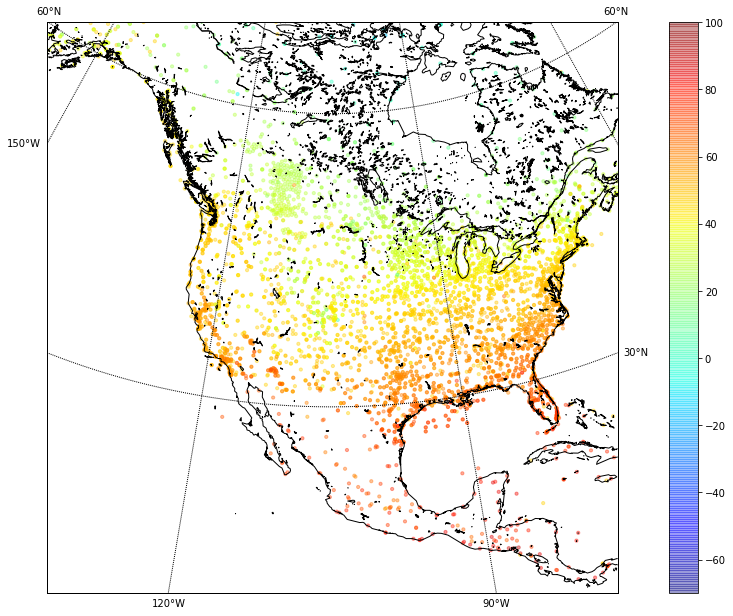

In [3]:
mapAvgTemperature(avgTemps,40,-105)

*Step 4: Map average daily temperature in Colorado in 2019  (degrees Fahrenheit)*

In [4]:
custom_colormap = \
    folium.StepColormap( ['purple','blue','green','yellow','orange','red'], 
                         vmin=0, vmax=100,
                         index=[0,20,40,60,80,100],
                        caption='Degrees Fahrenheit')

temperature_map = color_coded_map(co_only, 40,-105, 8)
temperature_map

*Step 4: Plot temperatures in Colorado (2010-2020, degrees Fahrenheit)*

In the city the avg daily temperatures mostly stay between 25F and 95F.

BOULDER MUNICIPAL AIRPORT :



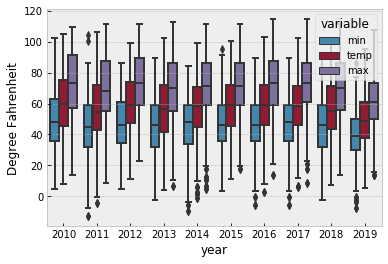

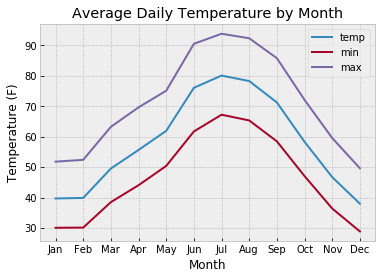

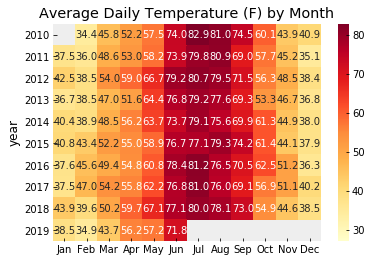

In [5]:
print("BOULDER MUNICIPAL AIRPORT"+' :\n')
displayTemperaturePlots(boulderWeather)

In the mountains the avg daily temperatures mostly stay between 5F and 55F.

BERTHOUD PASS :



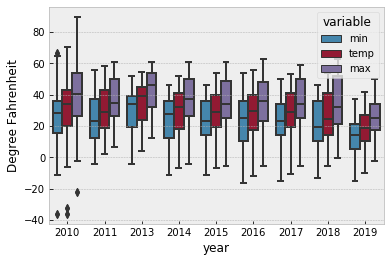

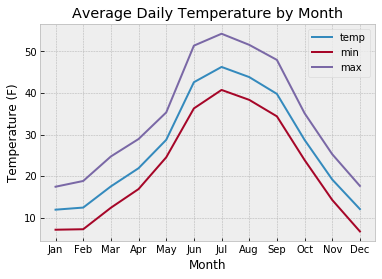

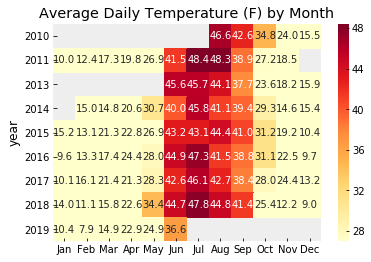

In [6]:
print("BERTHOUD PASS"+' :\n')
displayTemperaturePlots(mountainWeather)

There are many weather stations in Colorado.

In [7]:
plotPointsOnMap(co_only,0,500,'lat',lat,'lon',lon,8)

**Credit:**
* Some functions for mapping and plotting were adapted from https://www.kaggle.com/anhuang/visualization-of-global-climatic-change, https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps, and https://www.kaggle.com/tanatiem/eda-bangkok-weather.  See comments in code cells for more detail.